In [1]:
import os
import re
import mne
import scipy.io as sio
import numpy as np
import pandas as pd
from mne.preprocessing import ICA

# ------------------------------
# 1️⃣ Load MODMA EEG dataset
# ------------------------------
def load_modma_eeg_data(data_path):
    all_data = []

    # Map subject prefixes to labels
    label_map = {
        '0201': 1,  # MDD
        '0202': 0,  # HC
        '0203': 0   # HC
    }

    for root, dirs, files in os.walk(data_path):
        for filename in files:
            if filename.endswith('.mat') and 'subjects_information' not in filename:
                file_path = os.path.join(root, filename)
                
                subject_prefix = filename[:4]
                if subject_prefix not in label_map:
                    continue
                label = label_map[subject_prefix]

                subject_id = filename.split('_')[0]

                try:
                    mat_data = sio.loadmat(file_path)

                    # Handle inconsistent keys
                    clean_filename = filename[:-4].replace('restnew', 'rest_new')
                    clean_filename = re.sub(r'[\s_]+', '_', clean_filename)
                    possible_keys = ['a' + clean_filename.replace('.', '')]

                    found_key = None
                    for key in mat_data.keys():
                        for p_key in possible_keys:
                            if p_key.lower() in key.lower():
                                found_key = key
                                break
                        if found_key:
                            break

                    if found_key is None:
                        raise KeyError(f"No valid data key in {file_path}")

                    eeg_data = mat_data[found_key]
                    if eeg_data.shape[0] > eeg_data.shape[1]:
                        eeg_data = eeg_data.T

                    sfreq = 1000
                    ch_names = [f'EEG {i+1}' for i in range(eeg_data.shape[0])]
                    ch_types = ['eeg'] * eeg_data.shape[0]
                    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
                    raw = mne.io.RawArray(eeg_data, info)

                    all_data.append({'raw': raw, 'label': label, 'subject_id': subject_id})
                    print(f"Loaded {file_path} with label {label}")

                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")

    return all_data

data_path = '/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015'
dataset = load_modma_eeg_data(data_path)
print(f"\nTotal subjects loaded: {len(dataset)}")

Creating RawArray with float64 data, n_channels=129, n_times=75750
    Range : 0 ... 75749 =      0.000 ...    75.749 secs
Ready.
Loaded /kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02030007_rest 20151103 2032.mat with label 0
Creating RawArray with float64 data, n_channels=129, n_times=75513
    Range : 0 ... 75512 =      0.000 ...    75.512 secs
Ready.
Loaded /kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02030003_rest 20151022 1155.mat with label 0
Creating RawArray with float64 data, n_channels=129, n_times=76039
    Range : 0 ... 76038 =      0.000 ...    76.038 secs
Ready.
Loaded /kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02020010rest 20150625 1224..mat with label 0
Creating RawArray with float64 data, n_channels=129, n_times=83876
    Range : 0 ... 83875 =      0.000 ...    83.875 secs
Ready.
Loaded /kaggle/inp

In [2]:
# ------------------------------
# 2️⃣ Preprocess EEG
# ------------------------------
preprocessed_dir = '/kaggle/working/preprocessed_eeg'
os.makedirs(preprocessed_dir, exist_ok=True)

labels_csv = []
preprocessed_data = []

for item in dataset:
    raw = item['raw']
    label = item['label']
    subject_id = item['subject_id']

    # 1. Band-pass filter + notch
    raw.filter(l_freq=1.0, h_freq=45.0, fir_design='firwin', verbose=False)
    raw.notch_filter(freqs=[50, 100], fir_design='firwin', verbose=False)

    # 2. Common average reference
    raw.set_eeg_reference('average', verbose=False)

    # 3. ICA for artifact correction
    ica_raw = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    ica = ICA(n_components=20, max_iter='auto', random_state=42)
    ica.fit(ica_raw)
    raw = ica.apply(raw)

    # Save preprocessed .fif
    output_filename = f"{subject_id}_preprocessed_raw.fif"
    output_path = os.path.join(preprocessed_dir, output_filename)
    raw.save(output_path, overwrite=True)
    print(f"✅ Saved preprocessed data for {subject_id}")

    # Add to CSV
    labels_csv.append({'subject_id': subject_id, 'label': label})
    preprocessed_data.append({'raw': raw, 'label': label, 'subject_id': subject_id})

# Save labels CSV
labels_df = pd.DataFrame(labels_csv)
labels_df.to_csv(os.path.join(preprocessed_dir, 'labels.csv'), index=False)
print(f"\nSaved labels CSV at {preprocessed_dir}/labels.csv")
print(f"\nTotal subjects preprocessed: {len(preprocessed_data)}")

Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 21.3s.


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030007_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030007_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030007
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030003_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030003_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030003
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Trans

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030004_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030004_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030004
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030014rest 20151117 1441..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030014rest 20151117 1441..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030014rest 20151117 1441..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 com

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 21.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010024rest 20150814 1504..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010024rest 20150814 1504..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010024rest 20150814 1504..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010023rest 20150729 1929..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010023rest 20150729 1929..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010023rest 20150729 1929..mat
Fitting ICA to d

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010006rest 20150528 0928..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010006rest 20150528 0928..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010006rest 20150528 0928..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030021rest 20160105 1141..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030021rest 20160105 1141..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030021rest 20160105 1141..mat
Fitting ICA to data using 129 channels (

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030002rest_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030002rest_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030002rest
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010016rest 20150710 1220..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010016rest 20150710 1220..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010016rest 20150710 1220..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by nu

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010030rest 20160324 1054..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010030rest 20160324 1054..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010030rest 20160324 1054..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010011rest 20150625 1516..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010011rest 20150625 1516..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010011rest 20150625 1516..mat
Fitting ICA to data using 129 channels (

In [3]:
# ------------------------------
# 3️⃣ Reload preprocessed EEG + labels
# ------------------------------
reloaded_data = []
labels_df = pd.read_csv(os.path.join(preprocessed_dir, 'labels.csv'))

for filename in os.listdir(preprocessed_dir):
    if filename.endswith('.fif'):
        file_path = os.path.join(preprocessed_dir, filename)
        raw_obj = mne.io.read_raw_fif(file_path, preload=True)

        subject_id = filename.split('_')[0]
        label_row = labels_df[labels_df['subject_id'] == subject_id]
        if len(label_row) == 0:
            print(f"⚠️ Label not found for {subject_id}, skipping.")
            continue
        label = int(label_row['label'].values[0])

        reloaded_data.append({'raw': raw_obj, 'label': label, 'subject_id': subject_id})
        print(f"Loaded {filename} with label {label}")

print(f"\nTotal subjects reloaded: {len(reloaded_data)}")

Opening raw data file /kaggle/working/preprocessed_eeg/02020018rest 20150702 1651..mat_preprocessed_raw.fif...
Isotrak not found
    Range : 0 ... 75188 =      0.000 ...    75.188 secs
Ready.
Reading 0 ... 75188  =      0.000 ...    75.188 secs...
Loaded 02020018rest 20150702 1651..mat_preprocessed_raw.fif with label 0
Opening raw data file /kaggle/working/preprocessed_eeg/02010025 20160311 1206.mat.mat_preprocessed_raw.fif...
Isotrak not found
    Range : 0 ... 75175 =      0.000 ...    75.175 secs
Ready.
Reading 0 ... 75175  =      0.000 ...    75.175 secs...
Loaded 02010025 20160311 1206.mat.mat_preprocessed_raw.fif with label 1
Opening raw data file /kaggle/working/preprocessed_eeg/02020027rest 20150713 1049..mat_preprocessed_raw.fif...
Isotrak not found
    Range : 0 ... 83163 =      0.000 ...    83.163 secs
Ready.
Reading 0 ... 83163  =      0.000 ...    83.163 secs...
Loaded 02020027rest 20150713 1049..mat_preprocessed_raw.fif with label 0
Opening raw data file /kaggle/working/p

In [4]:
# Epoching (2-second windows)
X, y = [], []
sfreq = 128  # downsample to 128 Hz if needed
epoch_length = 2
samples_per_epoch = sfreq * epoch_length

for item in reloaded_data:
    raw = item['raw']
    label = item['label']
    
    # Resample if needed
    raw_resampled = raw.copy().resample(sfreq, npad="auto")

    data = raw_resampled.get_data()  # (n_channels, n_timepoints)
    n_channels, n_timepoints = data.shape

    n_epochs = n_timepoints // samples_per_epoch
    data = data[:, :n_epochs * samples_per_epoch]
    data = data.reshape(n_channels, n_epochs, samples_per_epoch)
    data = np.transpose(data, (1, 0, 2))  # (n_epochs, n_channels, timepoints)

    X.append(data)
    y.extend([label] * n_epochs)

X = np.concatenate(X, axis=0)
y = np.array(y)
print(f"✅ X shape: {X.shape}  # (total_epochs, n_channels, n_timepoints)")
print(f"✅ y shape: {y.shape}")

✅ X shape: (1902, 129, 256)  # (total_epochs, n_channels, n_timepoints)
✅ y shape: (1902,)


random forest feature extraction


In [5]:
from scipy.stats import skew, kurtosis
from mne.time_frequency import psd_array_welch
import numpy as np

def extract_features(epoch_data, sfreq=128):
    """
    Convert 2D epoch (n_channels, n_timepoints) into 1D feature vector
    """
    features = []
    for ch in range(epoch_data.shape[0]):
        signal = epoch_data[ch]

        # Time-domain
        features.append(signal.mean())
        features.append(signal.std())
        features.append(signal.min())
        features.append(signal.max())
        features.append(skew(signal))
        features.append(kurtosis(signal))

        # Frequency-domain
        psd, freqs = psd_array_welch(signal, sfreq=sfreq, fmin=1, fmax=45, n_fft=256, verbose=False)
        delta = psd[(freqs>=1) & (freqs<4)].mean()
        theta = psd[(freqs>=4) & (freqs<8)].mean()
        alpha = psd[(freqs>=8) & (freqs<13)].mean()
        beta  = psd[(freqs>=13) & (freqs<30)].mean()
        gamma = psd[(freqs>=30) & (freqs<=45)].mean()
        features.extend([delta, theta, alpha, beta, gamma])

    return np.array(features)


In [6]:
X_features = np.array([extract_features(epoch) for epoch in X])
y_labels = y
print(f"Feature matrix shape: {X_features.shape}")  # (1902, 1419)

Feature matrix shape: (1902, 1419)


In [7]:
print(f"Labels shape: {y_labels.shape}")

Labels shape: (1902,)


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from mne.time_frequency import psd_array_welch

def extract_separate_feature_tables(epoch_data, sfreq=128):
    """
    Extracts and returns two DataFrames:
    (1) Time-domain features
    (2) Frequency-domain features
    """
    time_features = []
    freq_features = []
    
    for ch in range(epoch_data.shape[0]):
        signal = epoch_data[ch]
        ch_name = f"Ch{ch+1}"

        # --- Time-domain ---
        mean_val = signal.mean()
        std_val = signal.std()
        min_val = signal.min()
        max_val = signal.max()
        skew_val = skew(signal)
        kurt_val = kurtosis(signal)

        time_features.append([ch_name, mean_val, std_val, min_val, max_val, skew_val, kurt_val])

        # --- Frequency-domain ---
        psd, freqs = psd_array_welch(signal, sfreq=sfreq, fmin=1, fmax=45, n_fft=256, verbose=False)
        delta = psd[(freqs>=1) & (freqs<4)].mean()
        theta = psd[(freqs>=4) & (freqs<8)].mean()
        alpha = psd[(freqs>=8) & (freqs<13)].mean()
        beta  = psd[(freqs>=13) & (freqs<30)].mean()
        gamma = psd[(freqs>=30) & (freqs<=45)].mean()

        freq_features.append([ch_name, delta, theta, alpha, beta, gamma])

    # Create DataFrames
    time_df = pd.DataFrame(time_features, columns=["Channel", "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis"])
    freq_df = pd.DataFrame(freq_features, columns=["Channel", "Delta", "Theta", "Alpha", "Beta", "Gamma"])

    return time_df, freq_df


# Example — simulate EEG epoch (3 channels, 256 samples)
np.random.seed(42)
epoch_data = np.random.randn(5, 256)

# Extract tables
time_df, freq_df = extract_separate_feature_tables(epoch_data)

print("Time-domain Feature Table:")
print(time_df.round(4))
print("\nFrequency-domain Feature Table:")
print(freq_df.round(6))

# Save (optional)
time_df.to_csv("time_domain_features.csv", index=False)
freq_df.to_csv("frequency_domain_features.csv", index=False)

Time-domain Feature Table:
  Channel    Mean     Std     Min     Max  Skewness  Kurtosis
0     Ch1  0.0008  0.9741 -2.6197  3.8527    0.3036    0.5084
1     Ch2  0.0080  0.9820 -3.2413  3.0789    0.0803    0.0062
2     Ch3 -0.0448  1.0097 -2.6969  2.6324    0.0743   -0.0561
3     Ch4  0.1535  0.9336 -2.4239  2.5269    0.0495   -0.2377
4     Ch5  0.0808  1.0247 -2.8963  2.5797   -0.0436   -0.1160

Frequency-domain Feature Table:
  Channel     Delta     Theta     Alpha      Beta     Gamma
0     Ch1  0.008889  0.008709  0.008613  0.015058  0.013865
1     Ch2  0.017357  0.013491  0.024791  0.014951  0.013169
2     Ch3  0.014690  0.012114  0.014181  0.020477  0.014962
3     Ch4  0.021977  0.009993  0.010043  0.016333  0.015275
4     Ch5  0.020112  0.018040  0.021754  0.010413  0.024786


=== Time-Domain Features ===
  Channel      Mean       Std       Min       Max  Skewness  Kurtosis
0     Ch1 -0.025886  1.027840 -2.839079  3.152057 -0.043078 -0.029679
1     Ch2 -0.110792  0.996160 -3.007632  2.349076 -0.178790 -0.017468
2     Ch3 -0.017449  0.953215 -2.837506  2.075065 -0.277696 -0.293404
3     Ch4 -0.047358  1.017006 -3.176704  3.076860 -0.224989  0.665131
4     Ch5  0.037638  0.976808 -2.220421  3.112910  0.122443 -0.020874 

=== Frequency-Domain Features ===
  Channel     Delta     Theta     Alpha      Beta     Gamma
0     Ch1  0.025903  0.014244  0.008880  0.024062  0.016301
1     Ch2  0.024742  0.014211  0.016280  0.018690  0.014291
2     Ch3  0.016134  0.012363  0.021247  0.012270  0.008735
3     Ch4  0.010544  0.009104  0.010534  0.017100  0.015761
4     Ch5  0.013079  0.013356  0.018763  0.016387  0.022845


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


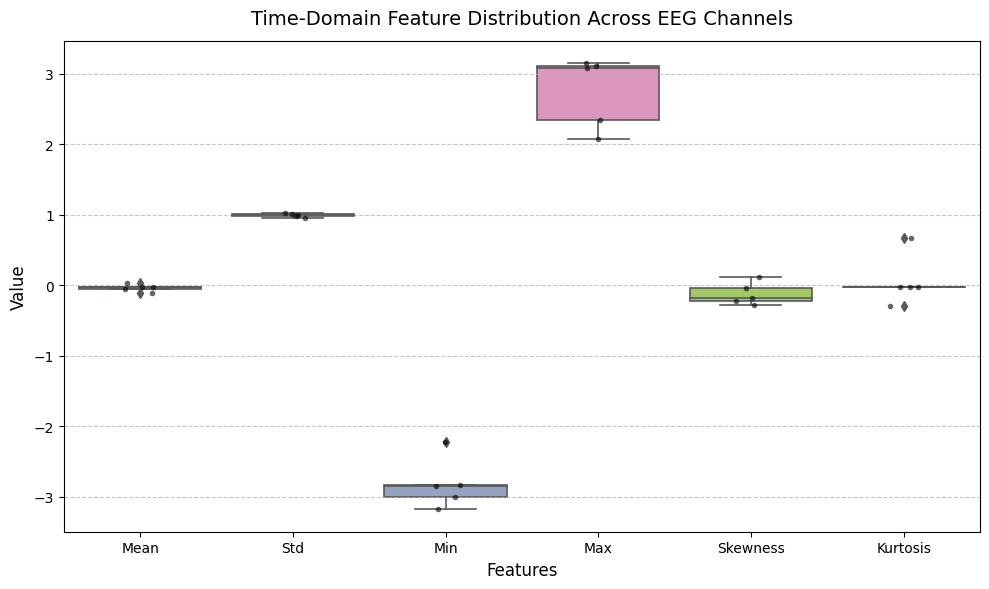

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert

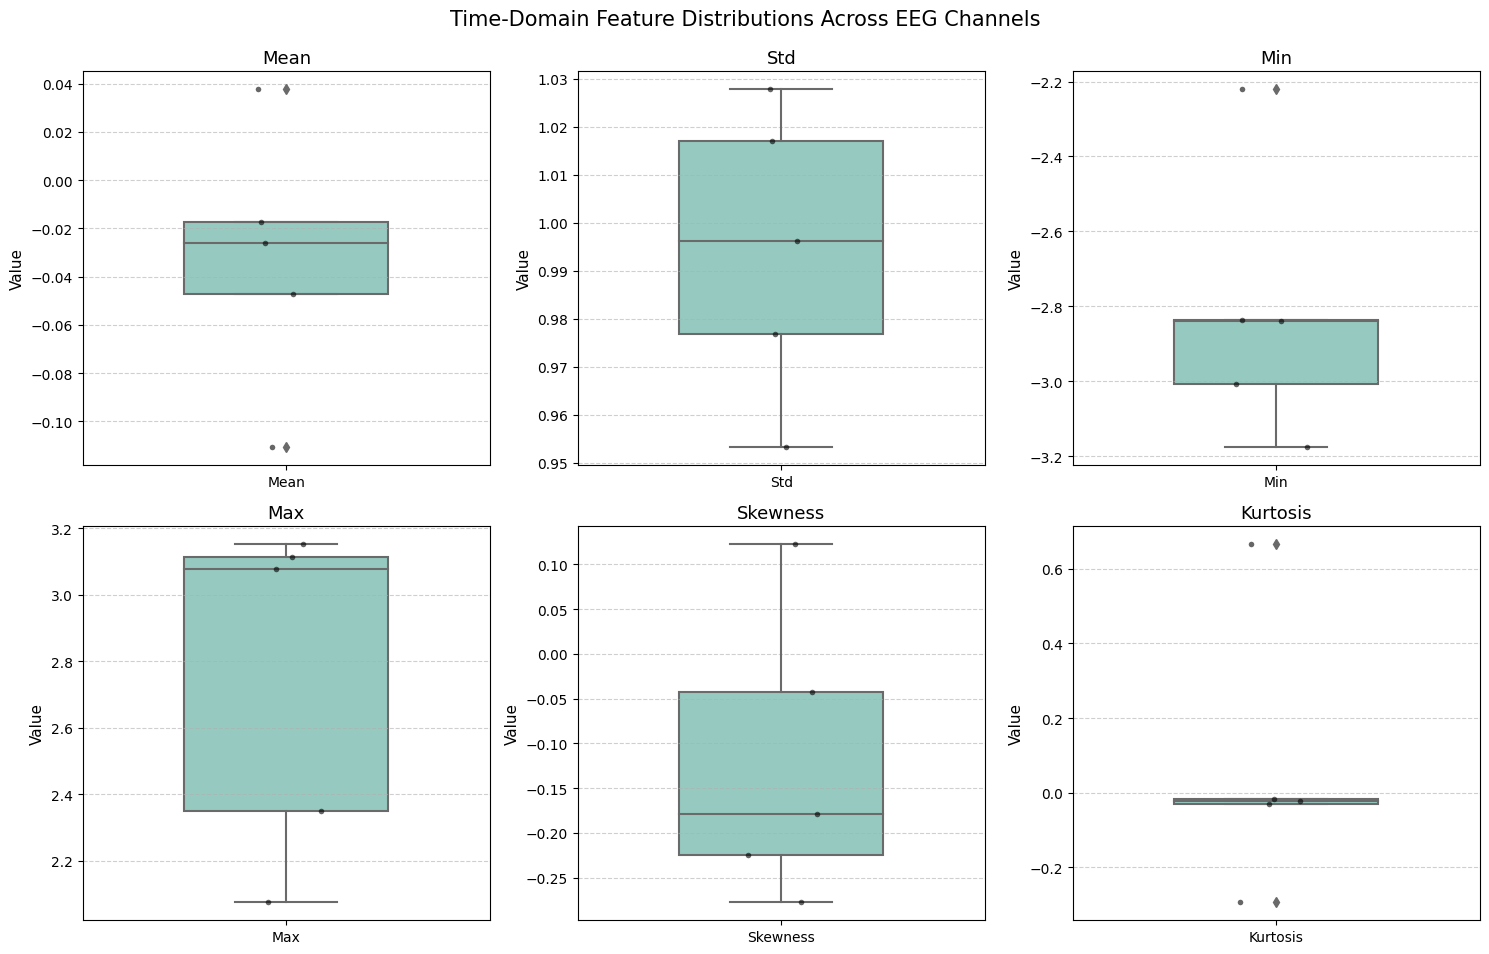

/tmp/ipykernel_37/1088312272.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=freq_melted, x='Band', y='Power', palette='viridis', ci='sd')


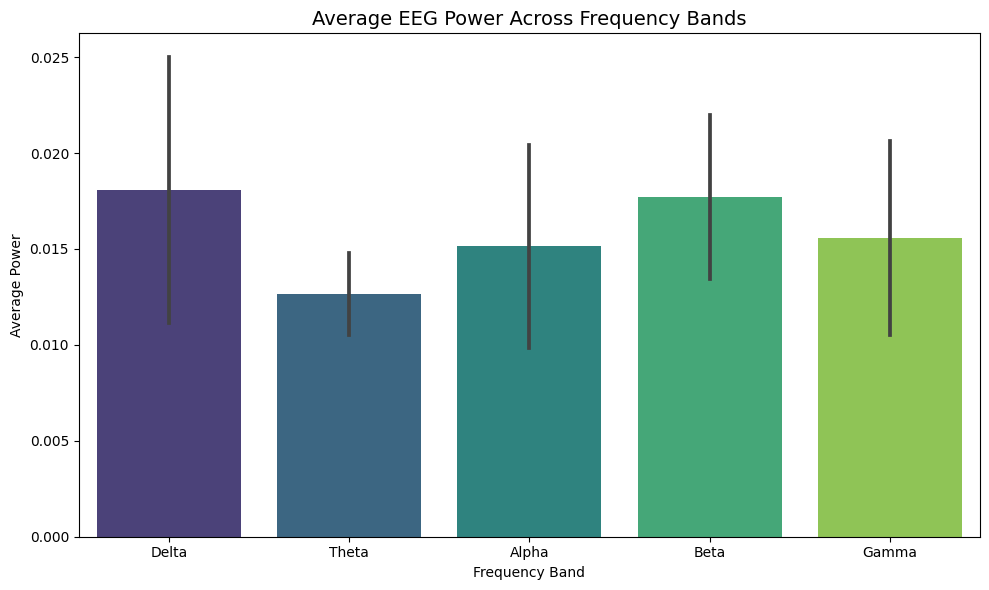

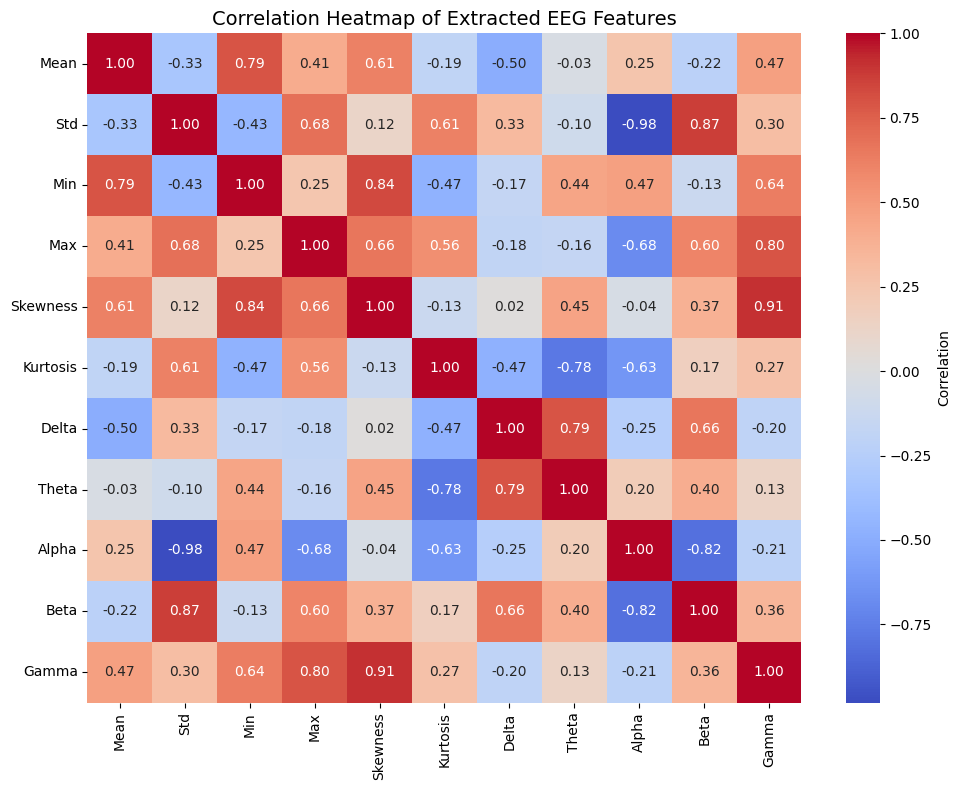

In [4]:
# =============================
# 📦 IMPORTS
# =============================
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from mne.time_frequency import psd_array_welch
import seaborn as sns
import matplotlib.pyplot as plt

# =============================
# 🧠 STEP 1: FEATURE EXTRACTION FUNCTION
# =============================
def extract_features_per_channel(epoch_data, sfreq=128):
    """
    Extract time and frequency domain features per channel and return DataFrames
    """
    time_features = []
    freq_features = []

    for ch in range(epoch_data.shape[0]):
        signal = epoch_data[ch]

        # --- Time-domain features ---
        mean = signal.mean()
        std = signal.std()
        min_val = signal.min()
        max_val = signal.max()
        skewness = skew(signal)
        kurt = kurtosis(signal)
        time_features.append([f"Ch{ch+1}", mean, std, min_val, max_val, skewness, kurt])

        # --- Frequency-domain features ---
        psd, freqs = psd_array_welch(signal, sfreq=sfreq, fmin=1, fmax=45, n_fft=256, verbose=False)
        delta = psd[(freqs>=1) & (freqs<4)].mean()
        theta = psd[(freqs>=4) & (freqs<8)].mean()
        alpha = psd[(freqs>=8) & (freqs<13)].mean()
        beta  = psd[(freqs>=13) & (freqs<30)].mean()
        gamma = psd[(freqs>=30) & (freqs<=45)].mean()
        freq_features.append([f"Ch{ch+1}", delta, theta, alpha, beta, gamma])

    # --- Convert to DataFrames ---
    time_df = pd.DataFrame(time_features, columns=["Channel", "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis"])
    freq_df = pd.DataFrame(freq_features, columns=["Channel", "Delta", "Theta", "Alpha", "Beta", "Gamma"])

    return time_df, freq_df

# =============================
# 🧩 STEP 2: LOAD OR SIMULATE EEG DATA
# =============================
# Replace this with your actual EEG epoch data (shape: n_channels × n_timepoints)
# For example, 5 channels × 256 samples (2 seconds at 128 Hz)
epoch_data = np.random.randn(5, 256)

# Extract features
time_features_df, freq_features_df = extract_features_per_channel(epoch_data)

# Display extracted features
print("=== Time-Domain Features ===")
print(time_features_df, "\n")
print("=== Frequency-Domain Features ===")
print(freq_features_df)

# =============================
# 📊 STEP 3: VISUALIZATIONS
# =============================

# ----- 1️⃣ Time-Domain Analysis: Box Plot -----
plt.figure(figsize=(10,6))
time_melted = time_features_df.melt(id_vars='Channel', var_name='Feature', value_name='Value')

sns.boxplot(data=time_melted, x='Feature', y='Value', palette='Set2', linewidth=1.2)
sns.stripplot(data=time_melted, x='Feature', y='Value', color='black', alpha=0.6, size=4)

plt.title("Time-Domain Feature Distribution Across EEG Channels", fontsize=14, pad=12)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ----- 1️⃣ Time-Domain Analysis: Separate Box Plots -----
time_melted = time_features_df.melt(id_vars='Channel', var_name='Feature', value_name='Value')

features = time_melted['Feature'].unique()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        data=time_melted[time_melted['Feature'] == feature],
        x='Feature', y='Value', palette='Set3', width=0.5
    )
    sns.stripplot(
        data=time_melted[time_melted['Feature'] == feature],
        x='Feature', y='Value', color='black', size=4, alpha=0.6
    )
    plt.title(feature, fontsize=13)
    plt.xlabel("")
    plt.ylabel("Value", fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("Time-Domain Feature Distributions Across EEG Channels", fontsize=15, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ----- 2️⃣ Frequency-Domain Analysis: Bar Plot -----
plt.figure(figsize=(10,6))
freq_melted = freq_features_df.melt(id_vars='Channel', var_name='Band', value_name='Power')
sns.barplot(data=freq_melted, x='Band', y='Power', palette='viridis', ci='sd')
plt.title("Average EEG Power Across Frequency Bands", fontsize=14)
plt.xlabel("Frequency Band")
plt.ylabel("Average Power")
plt.tight_layout()
plt.show()

# ----- 3️⃣ Correlation Analysis: Heatmap -----
combined_features = pd.concat([
    time_features_df.drop(columns=['Channel']),
    freq_features_df.drop(columns=['Channel'])
], axis=1)

plt.figure(figsize=(10,8))
sns.heatmap(combined_features.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap of Extracted EEG Features", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
!pip install xgboost


random forest

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# 2️⃣ Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 3️⃣ Predict on Test Set
y_pred = rf.predict(X_test)

# 4️⃣ Evaluate
print("Epoch-Level Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Epoch-Level Accuracy: 0.926509186351706

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       209
           1       0.95      0.88      0.92       172

    accuracy                           0.93       381
   macro avg       0.93      0.92      0.93       381
weighted avg       0.93      0.93      0.93       381


Confusion Matrix:
 [[201   8]
 [ 20 152]]


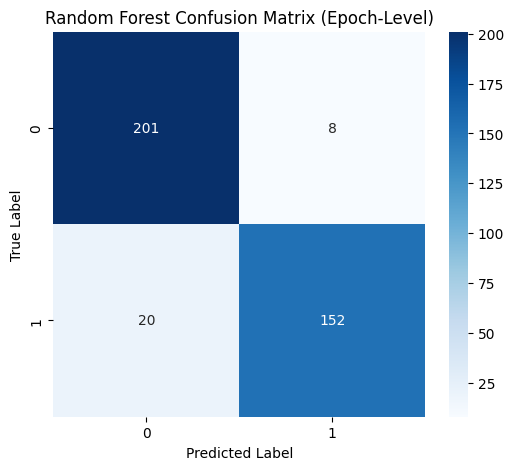

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix (Epoch-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

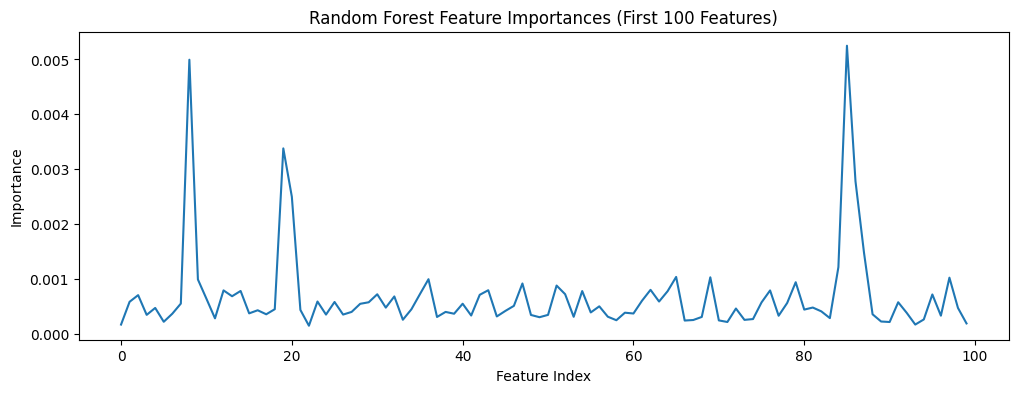

In [37]:
importances = rf.feature_importances_

# Plot first 100 features for readability
plt.figure(figsize=(12,4))
plt.plot(importances[:100])
plt.title("Random Forest Feature Importances (First 100 Features)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

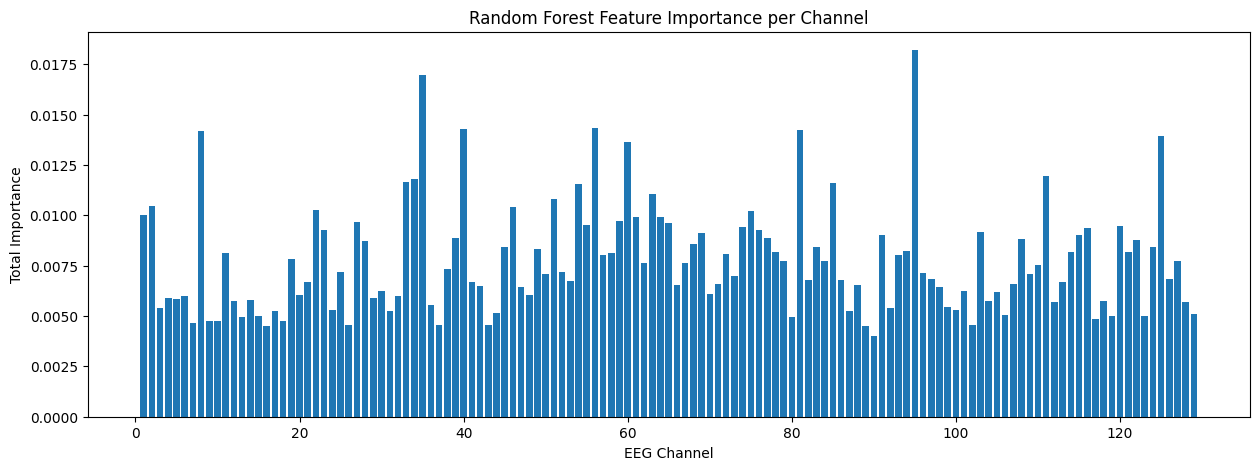

In [38]:
n_channels = 129
features_per_channel = 11  # 6 time-domain + 5 frequency bands

channel_importance = np.zeros(n_channels)
for ch in range(n_channels):
    start_idx = ch * features_per_channel
    end_idx = start_idx + features_per_channel
    channel_importance[ch] = importances[start_idx:end_idx].sum()

plt.figure(figsize=(15,5))
plt.bar(range(1, n_channels+1), channel_importance)
plt.title("Random Forest Feature Importance per Channel")
plt.xlabel("EEG Channel")
plt.ylabel("Total Importance")
plt.show()

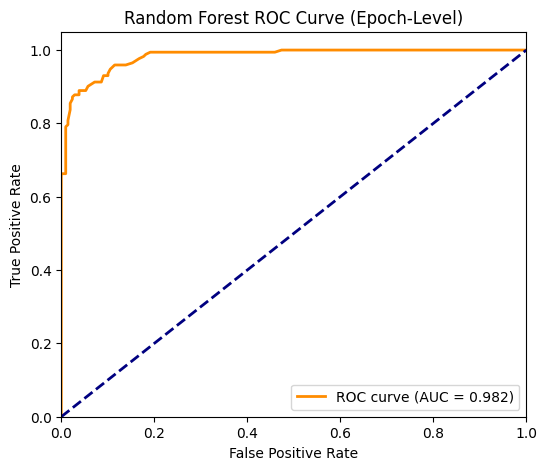

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for class 1 (MDD)
y_prob = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (Epoch-Level)')
plt.legend(loc="lower right")
plt.show()

✅ Training Accuracy: 1.000
✅ Validation Accuracy: 0.927


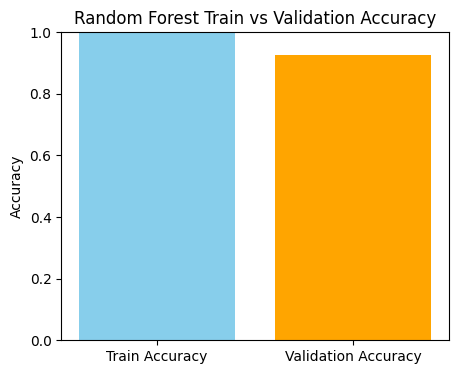

In [40]:
# Predict on training set
y_train_pred = rf.predict(X_train)

# Training accuracy
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, y_train_pred)
print(f"✅ Training Accuracy: {train_acc:.3f}")

# Already computed
val_acc = accuracy_score(y_test, y_pred)
print(f"✅ Validation Accuracy: {val_acc:.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['skyblue', 'orange'])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Random Forest Train vs Validation Accuracy")
plt.show()

In [41]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 1️⃣ Define the model (same hyperparameters as before)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2️⃣ Define a stratified 5-fold split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3️⃣ Run 5-fold cross-validation (using accuracy)
acc_scores = cross_val_score(rf, X_features, y_labels, cv=cv, scoring='accuracy')

# 4️⃣ Optionally, also check ROC-AUC consistency
auc_scores = cross_val_score(rf, X_features, y_labels, cv=cv, scoring='roc_auc')

# 5️⃣ Print results
print("5-Fold Accuracy Scores:", acc_scores)
print("Mean Accuracy:", np.mean(acc_scores))
print("Std Dev:", np.std(acc_scores))
print("5-Fold AUC Scores:", auc_scores)
print("Mean AUC:", np.mean(auc_scores))
print("Std Dev:", np.std(auc_scores))

5-Fold Accuracy Scores: [0.92650919 0.93175853 0.90789474 0.93421053 0.92631579]
Mean Accuracy: 0.9253377538334023
Std Dev: 0.00923623419021381
5-Fold AUC Scores: [0.98565984 0.98283632 0.9781751  0.98518425 0.97708386]
Mean AUC: 0.9817878748836039
Std Dev: 0.0035441964553854744



**xgboost**

In [14]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import xgboost as xgb

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize base XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# Stratified K-Fold to maintain class balance
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [19]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Make sure X_features and y_labels are your extracted feature matrix and labels
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit on training set
random_search.fit(X_train, y_train)

# Best parameters and CV score
print("✅ Best Parameters:", random_search.best_params_)
print("✅ Best CV Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
✅ Best CV Accuracy: 0.938198553583169


In [20]:
# Best estimator
best_xgb = random_search.best_estimator_

# Predict on test set
y_pred_best = best_xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

XGBoost Test Accuracy: 0.958005249343832

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       209
           1       0.97      0.94      0.95       172

    accuracy                           0.96       381
   macro avg       0.96      0.96      0.96       381
weighted avg       0.96      0.96      0.96       381


Confusion Matrix:
 [[204   5]
 [ 11 161]]
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=  38.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=  38.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=  38.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=  24.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total ti

✅ Reduced Accuracy XGBoost: 0.948

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       209
           1       0.96      0.92      0.94       172

    accuracy                           0.95       381
   macro avg       0.95      0.95      0.95       381
weighted avg       0.95      0.95      0.95       381



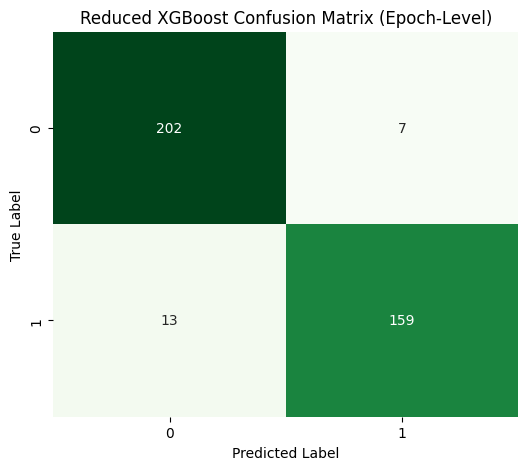

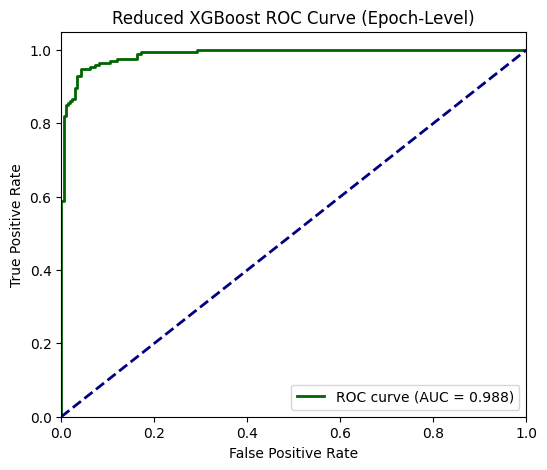

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1️⃣ Initialize XGBoost (Less Aggressive)
# ------------------------------
xgb_clf_reduced = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.15,
    subsample=0.7,
    colsample_bytree=0.5,
    reg_alpha=0.5,
    reg_lambda=2.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# ------------------------------
# 2️⃣ Train on Training Set
# ------------------------------
xgb_clf_reduced.fit(X_train, y_train)

# ------------------------------
# 3️⃣ Predict on Test Set
# ------------------------------
y_pred_reduced = xgb_clf_reduced.predict(X_test)
y_prob_reduced = xgb_clf_reduced.predict_proba(X_test)[:,1]

# ------------------------------
# 4️⃣ Accuracy and Classification Report
# ------------------------------
acc = accuracy_score(y_test, y_pred_reduced)
print(f"✅ Reduced Accuracy XGBoost: {acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))

# ------------------------------
# 5️⃣ Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred_reduced)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Reduced XGBoost Confusion Matrix (Epoch-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# 6️⃣ ROC Curve
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_reduced)
auc_score = roc_auc_score(y_test, y_prob_reduced)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reduced XGBoost ROC Curve (Epoch-Level)')
plt.legend(loc="lower right")
plt.show()

✅ Epoch-Level Accuracy: 0.948

Classification Report (Epoch-Level):
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       209
           1       0.96      0.92      0.94       172

    accuracy                           0.95       381
   macro avg       0.95      0.95      0.95       381
weighted avg       0.95      0.95      0.95       381



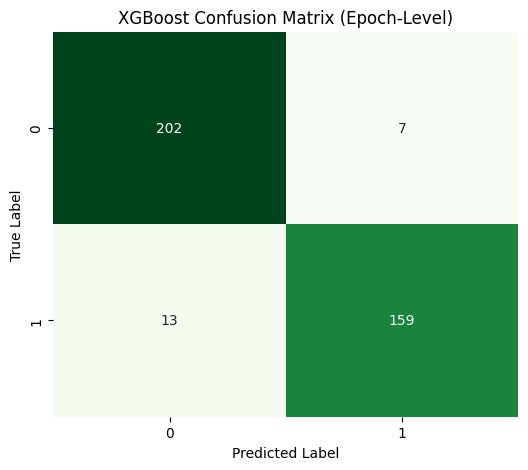

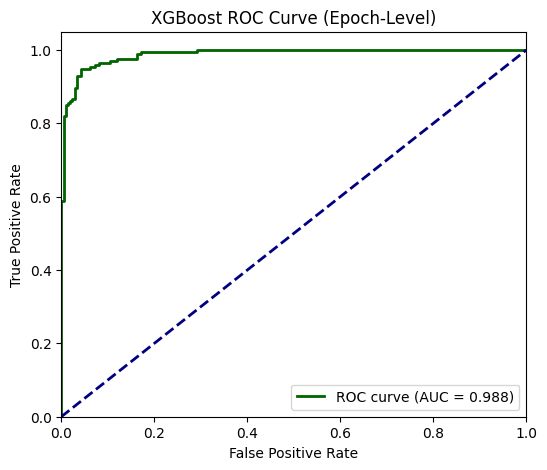

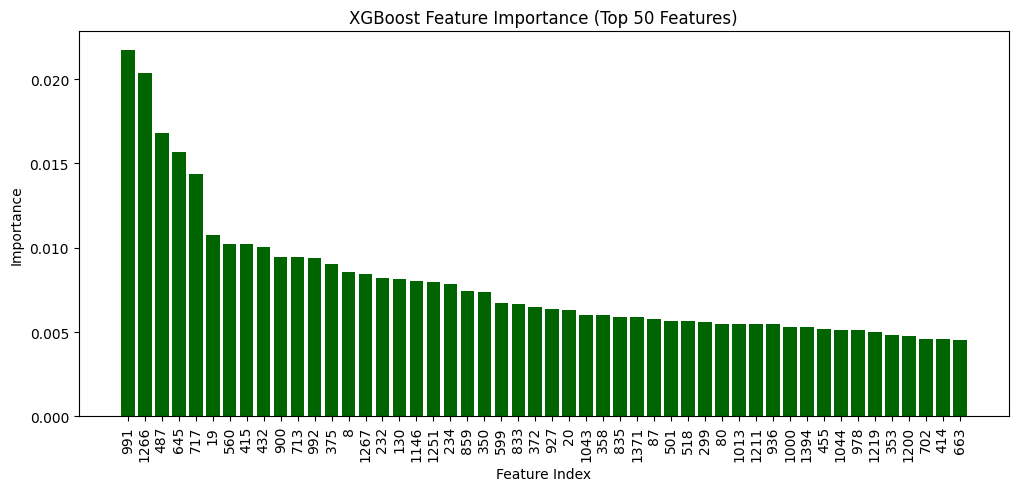


✅ Subject-Level Accuracy: 0.725

Classification Report (Subject-Level):
               precision    recall  f1-score   support

           0       0.77      0.77      0.77        31
           1       0.65      0.65      0.65        20

    accuracy                           0.73        51
   macro avg       0.71      0.71      0.71        51
weighted avg       0.73      0.73      0.73        51



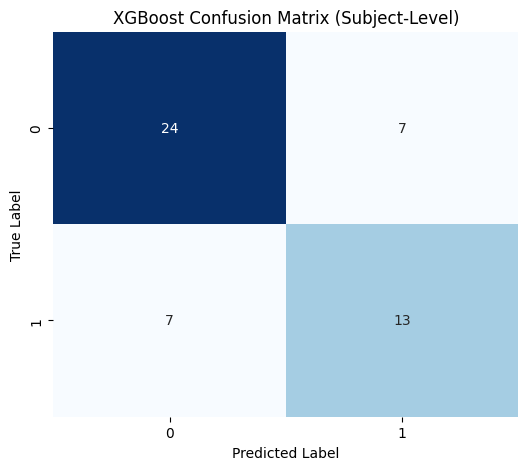

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from collections import Counter

# ------------------------------
# 1️⃣ Epoch-level Accuracy & Classification
# ------------------------------
y_pred_epoch = xgb_clf_reduced.predict(X_test)
y_prob_epoch = xgb_clf_reduced.predict_proba(X_test)[:, 1]

acc_epoch = accuracy_score(y_test, y_pred_epoch)
print(f"✅ Epoch-Level Accuracy: {acc_epoch:.3f}")
print("\nClassification Report (Epoch-Level):\n", classification_report(y_test, y_pred_epoch))

# ------------------------------
# 2️⃣ Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred_epoch)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("XGBoost Confusion Matrix (Epoch-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# 3️⃣ ROC Curve & AUC
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_epoch)
auc_score = roc_auc_score(y_test, y_prob_epoch)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Epoch-Level)')
plt.legend(loc="lower right")
plt.show()

# ------------------------------
# 4️⃣ Feature Importance (Top 50 Features)
# ------------------------------
importances = xgb_clf_reduced.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,5))
plt.bar(range(50), importances[indices][:50], color='darkgreen')
plt.xticks(range(50), indices[:50], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance (Top 50 Features)")
plt.show()

# ------------------------------
# 5️⃣ Subject-Level Aggregation
# ------------------------------
# Assuming you have a list `reloaded_data` with 'subject_id' per epoch
# And you already have `X_test` split from features with matching order
subject_ids_test = [item['subject_id'] for item in reloaded_data]  # repeat per epoch if necessary
# Make sure subject_ids_test matches the number of epochs in X_test
if len(subject_ids_test) != len(y_test):
    # replicate subject_id per epoch
    epoch_counts = []
    for item in reloaded_data:
        n_epochs = X_features.shape[1] // 256  # adjust depending on your epoching
        epoch_counts.append([item['subject_id']] * n_epochs)
    subject_ids_test = [sid for sublist in epoch_counts for sid in sublist]
subject_ids_test = np.array(subject_ids_test)[-len(y_test):]  # last X_test epochs

# Aggregate predictions by subject (majority vote)
subject_preds = {}
subject_labels = {}
for sid in np.unique(subject_ids_test):
    idx = np.where(subject_ids_test == sid)[0]
    votes = y_pred_epoch[idx]
    majority = Counter(votes).most_common(1)[0][0]
    subject_preds[sid] = majority
    subject_labels[sid] = y_test[idx][0]  # true label per subject

y_subject_true = np.array(list(subject_labels.values()))
y_subject_pred = np.array(list(subject_preds.values()))

# Subject-level metrics
acc_subject = accuracy_score(y_subject_true, y_subject_pred)
print(f"\n✅ Subject-Level Accuracy: {acc_subject:.3f}")
print("\nClassification Report (Subject-Level):\n", classification_report(y_subject_true, y_subject_pred))

# Subject-level confusion matrix
cm_subject = confusion_matrix(y_subject_true, y_subject_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_subject, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("XGBoost Confusion Matrix (Subject-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**logistic regression**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic Regression Epoch-Level Accuracy: 0.877

Classification Report (Epoch-Level):
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       209
           1       0.89      0.83      0.86       172

    accuracy                           0.88       381
   macro avg       0.88      0.87      0.87       381
weighted avg       0.88      0.88      0.88       381



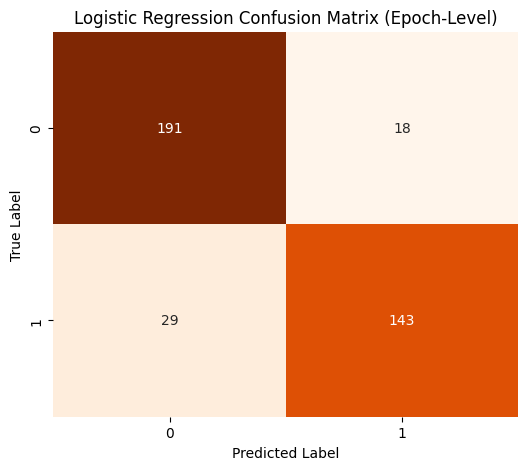

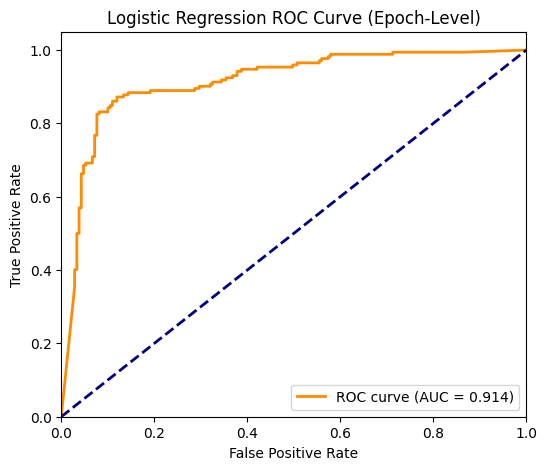


✅ Logistic Regression Subject-Level Accuracy: 0.667

Classification Report (Subject-Level):
               precision    recall  f1-score   support

           0       0.71      0.77      0.74        31
           1       0.59      0.50      0.54        20

    accuracy                           0.67        51
   macro avg       0.65      0.64      0.64        51
weighted avg       0.66      0.67      0.66        51



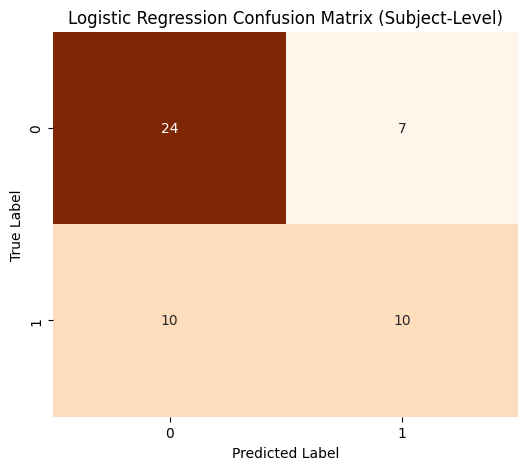

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ------------------------------
# 1️⃣ Train/Test Split
# ------------------------------
# X_features and y_labels are already your extracted feature matrix and labels
from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_features, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

# ------------------------------
# 2️⃣ Initialize Logistic Regression
# ------------------------------
lr_clf = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1,
    class_weight='balanced'  # helps if classes are imbalanced
)

# ------------------------------
# 3️⃣ Train Logistic Regression
# ------------------------------
lr_clf.fit(X_train_lr, y_train_lr)

# ------------------------------
# 4️⃣ Epoch-Level Predictions
# ------------------------------
y_pred_epoch_lr = lr_clf.predict(X_test_lr)
y_prob_epoch_lr = lr_clf.predict_proba(X_test_lr)[:, 1]

acc_epoch_lr = accuracy_score(y_test_lr, y_pred_epoch_lr)
print(f"✅ Logistic Regression Epoch-Level Accuracy: {acc_epoch_lr:.3f}")
print("\nClassification Report (Epoch-Level):\n", classification_report(y_test_lr, y_pred_epoch_lr))

# ------------------------------
# 5️⃣ Confusion Matrix
# ------------------------------
cm_lr = confusion_matrix(y_test_lr, y_pred_epoch_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Logistic Regression Confusion Matrix (Epoch-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# 6️⃣ ROC Curve
# ------------------------------
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_prob_epoch_lr)
auc_score_lr = roc_auc_score(y_test_lr, y_prob_epoch_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score_lr:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve (Epoch-Level)')
plt.legend(loc="lower right")
plt.show()

# ------------------------------
# 7️⃣ Subject-Level Aggregation
# ------------------------------
# Assuming you have subject IDs for each epoch in X_test_lr
subject_ids_test_lr = [item['subject_id'] for item in reloaded_data]  # replicate per epoch if necessary
if len(subject_ids_test_lr) != len(y_test_lr):
    epoch_counts = []
    for item in reloaded_data:
        n_epochs = X_features.shape[1] // 256  # adjust depending on epoching
        epoch_counts.append([item['subject_id']] * n_epochs)
    subject_ids_test_lr = [sid for sublist in epoch_counts for sid in sublist]
subject_ids_test_lr = np.array(subject_ids_test_lr)[-len(y_test_lr):]

# Majority vote per subject
subject_preds_lr = {}
subject_labels_lr = {}
for sid in np.unique(subject_ids_test_lr):
    idx = np.where(subject_ids_test_lr == sid)[0]
    votes = y_pred_epoch_lr[idx]
    majority = Counter(votes).most_common(1)[0][0]
    subject_preds_lr[sid] = majority
    subject_labels_lr[sid] = y_test_lr[idx][0]

y_subject_true_lr = np.array(list(subject_labels_lr.values()))
y_subject_pred_lr = np.array(list(subject_preds_lr.values()))

# Subject-level metrics
acc_subject_lr = accuracy_score(y_subject_true_lr, y_subject_pred_lr)
print(f"\n✅ Logistic Regression Subject-Level Accuracy: {acc_subject_lr:.3f}")
print("\nClassification Report (Subject-Level):\n", classification_report(y_subject_true_lr, y_subject_pred_lr))

# Confusion matrix for subject-level
cm_subject_lr = confusion_matrix(y_subject_true_lr, y_subject_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_subject_lr, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Logistic Regression Confusion Matrix (Subject-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()